## Content-based recommendation (using cosine similarity)
### Use article description to acquire similarity between articles

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import collaborative_filter as cf
import matplotlib.pyplot as plt

In [12]:
#read Menswear data set
transaction_men_raw = pd.read_csv("../data/large_data/transaction_2019_567_Menswear.csv")
transaction_men_raw.head()

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id,year,month,week,product_code,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,60,2019-05-01,00357b192b81fc83261a45be87f5f3d59112db7d117513...,743719001,0.050831,2,2019,5,18,743719,...,Shoes,F,Menswear,3,Menswear,27,Men Shoes,1020,Shoes,Cotton canvas trainers with a padded edge and ...
1,140,2019-05-01,0083ee250b3845008465de0e938d0ed2ae4f5bfde8b56e...,507431031,0.015237,2,2019,5,18,507431,...,Jersey inactive from s1,F,Menswear,3,Menswear,55,Contemporary Street,1005,Jersey Fancy,T-shirt in hard-washed slub cotton jersey with...
2,141,2019-05-01,0083ee250b3845008465de0e938d0ed2ae4f5bfde8b56e...,378447036,0.054220,2,2019,5,18,378447,...,Knitwear,F,Menswear,3,Menswear,23,Men Suits & Tailoring,1003,Knitwear,Jumper in fine-knit merino wool with a V-neck ...
3,142,2019-05-01,0083ee250b3845008465de0e938d0ed2ae4f5bfde8b56e...,657850001,0.030492,2,2019,5,18,657850,...,Knitwear,F,Menswear,3,Menswear,20,Contemporary Smart,1003,Knitwear,Jumper in a textured-knit wool blend with long...
4,143,2019-05-01,0083ee250b3845008465de0e938d0ed2ae4f5bfde8b56e...,598755015,0.013542,2,2019,5,18,598755,...,Light Basic Jersey,F,Menswear,3,Menswear,26,Men Underwear,1002,Jersey Basic,"Long, round-necked T-shirt in soft jersey with..."


In [13]:
print(transaction_men_raw.columns)

Index(['Unnamed: 0', 't_dat', 'customer_id', 'article_id', 'price',
       'sales_channel_id', 'year', 'month', 'week', 'product_code',
       'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')


In [14]:
%%time

AOP_results = []
MAP_results = []
num_users = []
timeline = []

# week 18 - 31
for wk in range(18,31):
    mask_train = transaction_men_raw.week == wk
    X_train = transaction_men_raw.loc[mask_train].reset_index(drop=True)
    mask_test = transaction_men_raw.week == wk+1
    X_test = transaction_men_raw.loc[mask_test].reset_index(drop=True)[['customer_id','article_id']]

    #concatenate all text information
    X_train['details_description'] = X_train['product_type_name'] + " " + \
                                     X_train['product_group_name'] + " " + \
                                     X_train['graphical_appearance_name'] + " " + \
                                     X_train['colour_group_name'] + " " + \
                                     X_train['perceived_colour_value_name'] + " " + \
                                     X_train['perceived_colour_master_name'] + " " + \
                                     X_train['department_name'] + " " + \
                                     X_train['section_name'] + " " + \
                                     X_train['garment_group_name'] + " " + \
                                     X_train['detail_desc']

    #subset article_id and description column
    article_desc_df = X_train[['article_id','details_description']].drop_duplicates().dropna().reset_index(drop=True)

    #TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(article_desc_df['details_description'])

    #Calculate cosine similarity between articles
    similarity = cosine_similarity(X)

    #sort index of similarity
    sorted_sim_index = np.fliplr(np.argsort(similarity))

    #find customers in training and their purchases items
    Customer_IDs = X_train.customer_id.unique()

    #dict to save customer_id and recommended article_ids
    recommended_items = {}

    for customer in Customer_IDs:

        #find items purchased by customer in training
        purchased = list(X_train.loc[X_train.customer_id == customer].article_id)

        #empty list to store similarity array for each purchased item
        similarity_items = []

        #for each article_id, find its 12 most similar items' similarites
        for each in purchased:

            #article_id's index
            item_index = np.where(article_desc_df.article_id == each)[0]

            if item_index.size == 1:
                item_index = item_index[0]
                #use article_id's index to get its similarity vectors with others and append to list
                similarity_items.append(similarity[item_index])

        #if no similarity item, go to next customer
        if len(similarity_items) == 0:
            break
        
        #convert similarity_items list to np array
        similarity_items = np.asarray(similarity_items)

        #replace 1. with 0 in the similarity_items (1 is the item itself)
        similarity_items[similarity_items > 0.999] = 0

        #Get index of 12 highest similarity for each purchased item
        high_sim_index = np.argpartition(similarity_items, -12)[:,-12:].flatten()

        #Get similarity using above index info
        high_similarity = np.take(similarity_items, high_sim_index).flatten()

        #make a dataframe
        item_index_sim_df = pd.DataFrame({"item_idx":high_sim_index, "similarity":high_similarity})
        #sort by similarity and get the first 12 items
        item_index_sim_df = item_index_sim_df.sort_values('similarity', ascending=False).reset_index(drop=True)[0:12]

        #retrieve the article_id by index
        recommend_article_ids = list(article_desc_df.article_id[list(item_index_sim_df.item_idx)])

        #add user_id and recommended items to dict
        recommended_items[customer] = recommend_article_ids

    #calculate AOP@12 for each train-test group
    AOP12_CB, num_user = cf.AOP(recommended_items, X_test)
    AOP_results.append(AOP12_CB)

    MAP12_CB, num_user = cf.MAP(recommended_items, X_test)
    MAP_results.append(MAP12_CB)
    
    #append number of users
    num_users.append(num_user)

    #append week to timeline
    timeline.append('Wk_'+str(wk+1))

 16%|████████████▌                                                                | 978/5993 [00:00<00:00, 9489.46it/s]

Number of users: 379


100%|████████████████████████████████████████████████████████████████████████████| 5993/5993 [00:00<00:00, 8542.57it/s]


Number of users: 379


 31%|███████████████████████▊                                                    | 1601/5098 [00:00<00:00, 7728.65it/s]

Number of users: 334


100%|████████████████████████████████████████████████████████████████████████████| 5098/5098 [00:00<00:00, 7367.76it/s]


Number of users: 334


 23%|█████████████████▏                                                          | 1308/5773 [00:00<00:00, 6461.09it/s]

Number of users: 411


100%|████████████████████████████████████████████████████████████████████████████| 5773/5773 [00:00<00:00, 6316.21it/s]


Number of users: 411


  8%|██████▏                                                                      | 566/6984 [00:00<00:01, 5617.75it/s]

Number of users: 533


100%|████████████████████████████████████████████████████████████████████████████| 6984/6984 [00:01<00:00, 5347.85it/s]


Number of users: 533


  9%|███████                                                                      | 755/8212 [00:00<00:00, 7478.93it/s]

Number of users: 534


100%|████████████████████████████████████████████████████████████████████████████| 8212/8212 [00:01<00:00, 6992.97it/s]


Number of users: 534


 25%|███████████████████▏                                                        | 1586/6289 [00:00<00:00, 7873.49it/s]

Number of users: 396


100%|████████████████████████████████████████████████████████████████████████████| 6289/6289 [00:00<00:00, 7344.77it/s]


Number of users: 396


  8%|█████▊                                                                       | 479/6336 [00:00<00:01, 4754.55it/s]

Number of users: 583


100%|████████████████████████████████████████████████████████████████████████████| 6336/6336 [00:01<00:00, 4001.70it/s]


Number of users: 583


  8%|██████▏                                                                      | 791/9897 [00:00<00:02, 3918.31it/s]

Number of users: 1003


100%|████████████████████████████████████████████████████████████████████████████| 9897/9897 [00:02<00:00, 3478.89it/s]


Number of users: 1003


 10%|███████▏                                                                   | 1070/11093 [00:00<00:02, 4869.89it/s]

Number of users: 885


100%|██████████████████████████████████████████████████████████████████████████| 11093/11093 [00:02<00:00, 4686.06it/s]


Number of users: 885


 12%|████████▊                                                                   | 1074/9243 [00:00<00:01, 5410.60it/s]

Number of users: 702


100%|████████████████████████████████████████████████████████████████████████████| 9243/9243 [00:01<00:00, 5078.00it/s]


Number of users: 702


  8%|█████▉                                                                       | 621/8023 [00:00<00:01, 6103.34it/s]

Number of users: 575


100%|████████████████████████████████████████████████████████████████████████████| 8023/8023 [00:01<00:00, 5791.78it/s]


Number of users: 575


 77%|██████████████████████████████████████████████████████████▉                 | 1039/1341 [00:00<00:00, 5226.37it/s]

Number of users: 84


100%|████████████████████████████████████████████████████████████████████████████| 1341/1341 [00:00<00:00, 5235.01it/s]


Number of users: 84


 39%|█████████████████████████████▌                                             | 3491/8844 [00:00<00:00, 15244.67it/s]

Number of users: 351


100%|███████████████████████████████████████████████████████████████████████████| 8844/8844 [00:00<00:00, 15019.45it/s]

Number of users: 351
Wall time: 4min 27s


In [15]:
print(AOP_results)
print(MAP_results)
print(num_users)

[0.028144239226033426, 0.02395209580838322, 0.017639902676399016, 0.018136335209505937, 0.022627965043695374, 0.01578282828282828, 0.019868496283590623, 0.01595214356929213, 0.0181732580037665, 0.01614434947768282, 0.017826086956521735, 0.010912698412698412, 0.018518518518518514]
[0.03853711762682739, 0.03128647106940519, 0.020841649901868882, 0.022698710503588557, 0.02959429208258797, 0.015353366821169851, 0.024033739749863253, 0.02145334678983732, 0.022276402714255815, 0.019049254928884558, 0.021501301838258362, 0.011377236079617032, 0.027437822808193194]
[379, 334, 411, 533, 534, 396, 583, 1003, 885, 702, 575, 84, 351]


In [16]:
#save results in a dataframe
result_df = pd.DataFrame({'timeline':timeline,
                          'AOP':AOP_results,
                          'MAP':MAP_results,
                          'num_users':num_users})

#save the dataframe in csv
#change file name for different period groups
#result_df.to_csv("../data/MenswearResults/content-based.csv")

result_df.head()

,timeline,AOP,MAP,num_users
0,Wk_19,0.028144,0.038537,379
1,Wk_20,0.023952,0.031286,334
2,Wk_21,0.017640,0.020842,411
3,Wk_22,0.018136,0.022699,533
4,Wk_23,0.022628,0.029594,534


In [17]:
#Read result csv
CB_df = pd.read_csv("../data/MenswearResults/content-based.csv").iloc[:,1:]
CB_df

,timeline,AOP,MAP,num_users
0,Wk_19,0.028144,0.038537,379
1,Wk_20,0.023952,0.031286,334
2,Wk_21,0.017640,0.020842,411
3,Wk_22,0.018136,0.022699,533
4,Wk_23,0.022628,0.029594,534
5,Wk_24,0.015783,0.015353,396
6,Wk_25,0.019868,0.024034,583
7,Wk_26,0.015952,0.021453,1003
8,Wk_27,0.018173,0.022276,885
9,Wk_28,0.016144,0.019049,702


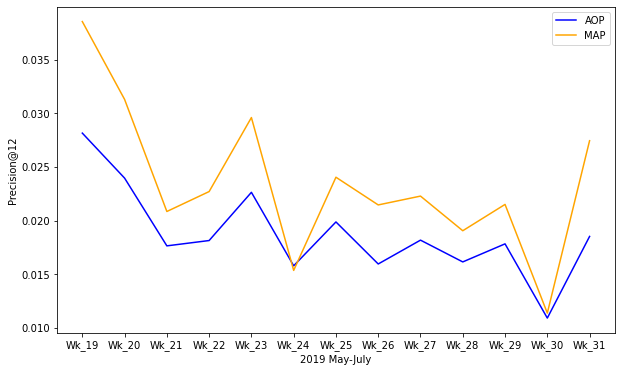

In [19]:
#plot for AOP MAP
plt.figure(figsize=(10,6))
plt.plot(CB_df.timeline, CB_df.AOP, color= 'blue')
plt.plot(CB_df.timeline, CB_df.MAP, color= 'orange')
plt.xlabel('2019 May-July')
plt.ylabel('Precision@12')
plt.legend(['AOP','MAP'])

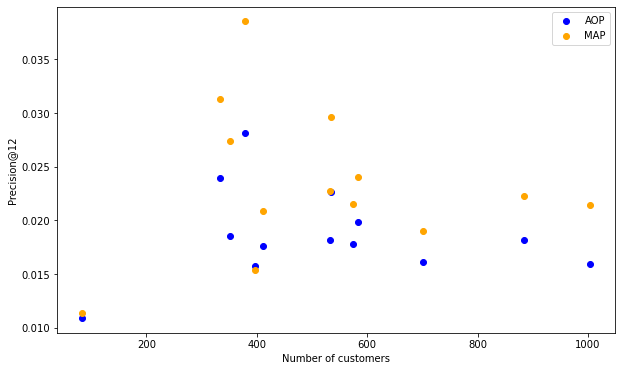

In [20]:
#scatter plot for AOP and number of users
plt.figure(figsize=(10,6))
plt.scatter(CB_df.num_users, CB_df.AOP, color = 'blue')
plt.scatter(CB_df.num_users, CB_df.MAP, color = 'orange')
plt.xlabel('Number of customers')
plt.ylabel('Precision@12')
plt.legend(['AOP','MAP'])

## Step-by-step 

#### Step 1. Get training and testing data 

In [21]:
mask_train = transaction_men_raw.week == 20
X_train = transaction_men_raw.loc[mask_train].reset_index(drop=True)
mask_test = transaction_men_raw.week == 21
X_test = transaction_men_raw.loc[mask_test].reset_index(drop=True)[['customer_id','article_id']]

#### Step 2. Concatenate article information (use text info) 

In [22]:
X_train['details_description'] = X_train['product_type_name'] + " " + \
                                 X_train['product_group_name'] + " " + \
                                 X_train['graphical_appearance_name'] + " " + \
                                 X_train['colour_group_name'] + " " + \
                                 X_train['perceived_colour_value_name'] + " " + \
                                 X_train['perceived_colour_master_name'] + " " + \
                                 X_train['department_name'] + " " + \
                                 X_train['section_name'] + " " + \
                                 X_train['garment_group_name'] + " " + \
                                 X_train['detail_desc']

#### Step3. subset article_id and description column

In [23]:
article_desc_df = X_train[['article_id','details_description']].drop_duplicates().dropna().reset_index(drop=True)
article_desc_df

,article_id,details_description
0,570003036,T-shirt Garment Upper body Stripe Turquoise Du...
1,570002007,T-shirt Garment Upper body Melange Greenish Kh...
2,378135029,Sweater Garment Upper body Solid Dark Green Da...
3,566942004,Swimwear bottom Swimwear Solid Dark Blue Brigh...
4,495030002,Socks Socks & Tights Solid Black Dark Black So...
...,...,...
2723,728830001,Sneakers Shoes Solid White Light White Shoes M...
2724,219075021,Trousers Garment Lower body Solid Black Dark B...
2725,611020017,Trousers Garment Lower body Denim Light Blue L...
2726,452516005,Trousers Garment Lower body Melange Dark Blue ...


#### Step4.Perform TF-IDF (Term Frequency - Inverse Document Frequency)

Ref: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [24]:
#TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(article_desc_df['details_description'])
X

<2728x834 sparse matrix of type '<class 'numpy.float64'>'
	with 82872 stored elements in Compressed Sparse Row format>

#### Step5. Calculate cosine similarity

In [25]:
#Calculate cosine similarity between articles
similarity = cosine_similarity(X)
similarity

array([[1.        , 0.45134029, 0.11023422, ..., 0.06892729, 0.01241718,
        0.1474869 ],
       [0.45134029, 1.        , 0.1833775 , ..., 0.04359583, 0.03097309,
        0.13929669],
       [0.11023422, 0.1833775 , 1.        , ..., 0.02575353, 0.14017002,
        0.22055829],
       ...,
       [0.06892729, 0.04359583, 0.02575353, ..., 1.        , 0.19876335,
        0.05270778],
       [0.01241718, 0.03097309, 0.14017002, ..., 0.19876335, 1.        ,
        0.16078109],
       [0.1474869 , 0.13929669, 0.22055829, ..., 0.05270778, 0.16078109,
        1.        ]])

In [26]:
#sort index of similarity
sorted_sim_index = np.fliplr(np.argsort(similarity))
sorted_sim_index

array([[   0,  901, 2114, ..., 1954, 2721, 2668],
       [   1,  623,  394, ..., 1979, 1954, 2721],
       [   2, 2635, 2226, ..., 1602, 1493, 1731],
       ...,
       [2725,  688, 2542, ..., 2462,  240, 2111],
       [2726,  424,  286, ..., 1493, 1596, 2111],
       [2727, 1920, 2174, ..., 1829, 2530, 2334]], dtype=int64)

In [27]:
#find customers in training and their purchases items
Customer_IDs = X_train.customer_id.unique()

#dict to save customer_id and recommended article_ids
recommended_items = {}

#### Step6. Loop through each customer in training data and identify their recommended items

1. find out what items a customer had purchased
2. for each item, find its similar items
3. Select top 12 similar items as recommended items

In [28]:
for customer in Customer_IDs:

        #find items purchased by customer in training
        purchased = list(X_train.loc[X_train.customer_id == customer].article_id)

        #empty list to store similarity array for each purchased item
        similarity_items = []

        #for each article_id, find its 12 most similar items' similarites
        for each in purchased:

            #article_id's index
            item_index = np.where(article_desc_df.article_id == each)[0]

            if item_index.size == 1:
                item_index = item_index[0]
                #use article_id's index to get its similarity vectors with others and append to list
                similarity_items.append(similarity[item_index])

        #if no similarity item, go to next customer
        if len(similarity_items) == 0:
            break
        
        #convert similarity_items list to np array
        similarity_items = np.asarray(similarity_items)

        #replace 1. with 0 in the similarity_items (1 is the item itself)
        similarity_items[similarity_items > 0.999] = 0

        #Get index of 12 highest similarity for each purchased item
        high_sim_index = np.argpartition(similarity_items, -12)[:,-12:].flatten()

        #Get similarity using above index info
        high_similarity = np.take(similarity_items, high_sim_index).flatten()

        #make a dataframe
        item_index_sim_df = pd.DataFrame({"item_idx":high_sim_index, "similarity":high_similarity})
        #sort by similarity and get the first 12 items
        item_index_sim_df = item_index_sim_df.sort_values('similarity', ascending=False).reset_index(drop=True)[0:12]

        #retrieve the article_id by index
        recommend_article_ids = list(article_desc_df.article_id[list(item_index_sim_df.item_idx)])

        #add user_id and recommended items to dict
        recommended_items[customer] = recommend_article_ids

In [29]:
recommended_items

{'00cc7b20c3598962935bb62755b952a9c6517e0cb869195f352335fa998ac1da': [542533018,
  783543004,
  685816013,
  570004005,
  570002033,
  570003031,
  570003055,
  570003054,
  736765002,
  570003042,
  614460011,
  480304005],
 '01179a3b2c4f0a9d447b44a6d0e3bd6ba79ac85f1f40de787bc6efbcbd16b381': [727808004,
  495685003,
  727808003,
  378447036,
  727808005,
  647781002,
  378447002,
  647781001,
  647781004,
  647781003,
  657852007,
  564358039],
 '0198f1ec9513d4fab06a33dffba49746707b838f90ac4faed79986a0dee5c09f': [495030020,
  495030001,
  750553001,
  750553002,
  750553003,
  718381002,
  575347003,
  301227002,
  575347011,
  452818001,
  452818029,
  301227017],
 '022df8068a48bc81eb90cbb500c05d25e00fd4374948adf4146b0e71164f041c': [731851001,
  645749005,
  338016001,
  338016009,
  337991006,
  467738003,
  337991002,
  544181001,
  481696001,
  677917001,
  732712003,
  544181002],
 '0255d2ae6c3cb02f410df152c53942f1eb0d8e36d99a35e59581d108fbe7e48c': [641748012,
  641748007,
  6417

#### Step7. Calcuate AOP and MAP

In [30]:
#calculate AOP@12 for each train-test group
AOP12_CB, num_user = cf.AOP(recommended_items, X_test)
#AOP_results.append(AOP12_CB)

MAP12_CB, num_user = cf.MAP(recommended_items, X_test)
#MAP_results.append(MAP12_CB)

 24%|█████████████████▉                                                          | 1366/5773 [00:00<00:00, 6532.07it/s]

Number of users: 411


100%|████████████████████████████████████████████████████████████████████████████| 5773/5773 [00:00<00:00, 6350.60it/s]

Number of users: 411


In [31]:
print(AOP12_CB)
print(MAP12_CB)
print(num_user)

0.017639902676399016
0.020841649901868882
411
